# Chapter 5 Gelman 
# question 3

## Problem

> Reproduce the computations in Section 5.5 for the educational testing example. Use the posterior simulations to estimate (i) for each school $j$, the probability that its coaching program is the best of the eight; and (ii) for each pair of schools, $j$ and $k$, the probability that the coaching program in school $j$ is better than that in school $k$.
## Model 

The first thing we need to do is clearly establish the full model that we will be using. We start with the model for individual students $y_{ij}$:

$$y_{ij}|\theta_j, \sigma_j \sim \text{N}(\theta_j, \sigma^2_j)$$
So the coaching effect on individual students in school $j$ is normal distributed around $\theta_j$, the average effect for the school. Because we have reason to believe that coaching programs will be similar, we can partially pool information across schools by adding the hierarchical prior:

$$\theta_j \sim \text{N}(\mu, \tau)$$

This allows the data at each school to impact our estimate of all other schools through the hyperparameters $\mu$ and $\tau$, while also providing an separate estimate for each school. 

Assuming the $\sigma_j$ are fixed, we are left only with the question of priors for $\mu$ and $\tau$. After some searching through the book, we find the prior:

$$ p(\mu, \tau) \propto 1 $$

That is, a joint improper uniform prior on both parameters, equivalent to $p(\mu) \propto 1$ and $p(\tau) \propto 1$. We could also choose fixed values for $\mu$ and $\tau$ for our analysis. However, generally with a hierarchical model the desire is for the data to inform the grand mean ($\mu$) and variance ($\tau^2$), which is only possible with hyperpriors for $\mu$ and $\tau$. 

The full model is then

$$ \begin{align*}
y_{ij}|\theta_j, \sigma_j &\sim \text{N}(\theta_j, \sigma^2_j) \\
\theta_j &\sim \text{N}(\mu, \tau) \\
p(\mu) &\propto 1 \\
p(\tau) &\propto 1
\end{align*} $$

## Computation Strategy

Our simulation strategy will be to first make random draws from the marginal posterior distribution of $\tau$ and $\mu$, then use those values to sample the $\theta_j$. This works well because the $\theta_j$ are conditional independent given $\mu$ and $\tau$. Fortunately, the book provides the general form for the posterior distribution of $\tau$ in (5.21):

$$p(\tau|y) \propto p(\tau) V^{-1/2}_\mu \prod_{j=1}^J(\sigma^2_j + \tau^2)^{-1/2}\text{exp}
  \left(-\frac{(\bar{y}_{.j} - \hat{\mu})^2}{2(\sigma^2_j + \tau^2)}\right)$$
  
where, from (5.20) in the book:

$$ \begin{align*}
\hat{\mu} &= \frac{\sum_{j=1}^J \frac{1}{\sigma^2_j + \tau^2} \bar{y}_{.j}}{\sum_{j=1}^J \frac{1}{\sigma^2_j + \tau^2}} \\
V_\mu^{-1} &= \sum_{j=1}^J\frac{1}{\sigma^2_j + \tau^2}
\end{align*}$$

### Plotting the Posterior of $\tau$

Unfortunately, this is a huge mess and not a recognizable distribution for $\tau$. Simulating $\tau|y$ becomes the hardest part of this problem (given the math already done for us), and it's a little surprising they just swept this under the rug (it's mentioned at the top of page 118 that you need to use the inverse cdf method, but the referenced section doesn't explain how to do this for an unknown distribution). To get a handle on this, first let's get an idea of what the posterior of $\tau$ looks like. To do this, we'll just choose a bunch of values of $\tau$ and run them through the mess of expressions above, given the data at the top of page 120.





In [ ]:
install.packages("kableExtra")
library(ggplot2)
library(tidyr)
library(knitr)
library(kableExtra)

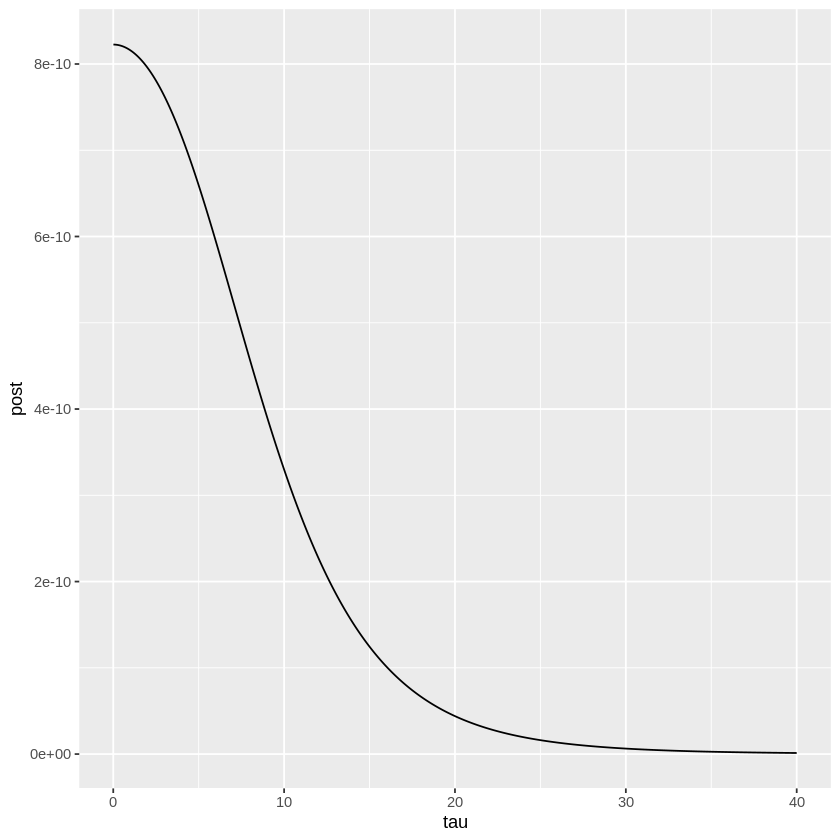

In [ ]:
y = c(28, 8, -3, 7, -1, 1, 18, 12)
sigma2 = c(15, 10, 16, 11, 9, 11, 10, 18)^2
J = length(y)
var_inv = function(sigma2, tau){
  sum(1/(sigma2+tau^2))
}
mu_hat = function(y, sigma2, tau){
  sum(1/(sigma2+tau^2) * y) / var_inv(sigma2, tau)
}
post_tau = function(y, sigma2, tau, mu_h){
  var_inv(sigma2, tau)^(-1/2)  * prod((sigma2 + tau^2)^(-1/2) * exp(-(y - mu_h)^2 / (2*(sigma2 + tau^2))))
}
interval = 0.01
max = 30
tau = (1:(max/interval)) * interval
post = tau
for (i in 1:length(tau)){
  mu_h = mu_hat(y, sigma2, tau[i])
  post[i] = post_tau(y, sigma2, tau[i], mu_h)
}
posterior = data.frame(tau, post)
g = ggplot(posterior, aes(tau, post)) + geom_line()
g

Seeing this plot gives us a good sanity check on the posterior of $\tau$. The mass toward 0 indicates that there is not really strong evidence that the $\theta_j$ are indeed distinct ($\tau = 0$ corresponds to no difference between schools). Also, the standard deviation of the $y_{.j}$ is 10.4, so we have very little support in the data for values of $\tau$ beyond 20.

## Simulating From $p(\tau|y)$

We can now use the same values we plotted to get the shape of the posterior to simulate from it approximately. It seems safe to limit our sampled values of $\tau$ between 0 and 30 given how little posterior mass lies outside this range. We first compute the approximate cdf of $\tau|y$ by normalizing the values from the plot above and finding the cumulative sum of these values (times the chosen interval between values of $\tau$).




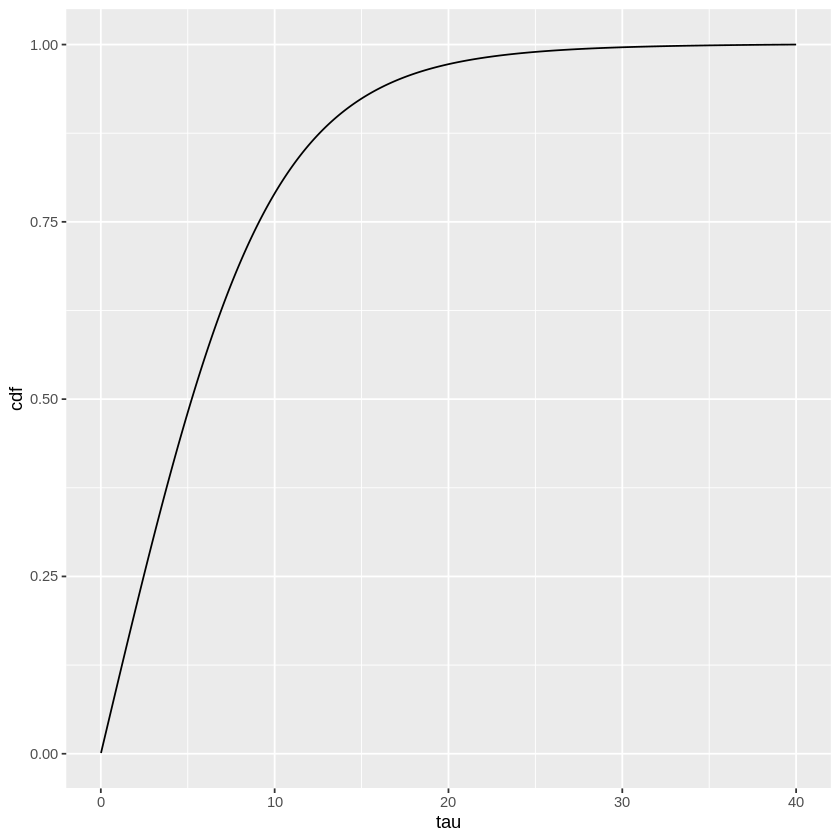

In [ ]:
norm_post = post / sum(post * interval)
cdf = cumsum(norm_post) * interval
cdf_df = data.frame(tau, cdf)
ggplot(cdf_df, aes(tau, cdf)) + geom_line()

We can see that this monotonically approaches 1, as desired for a cdf. Now we can simluate uniform random values between 0 and 1, and use this cdf to map those values to the distribution of $\tau_y$.




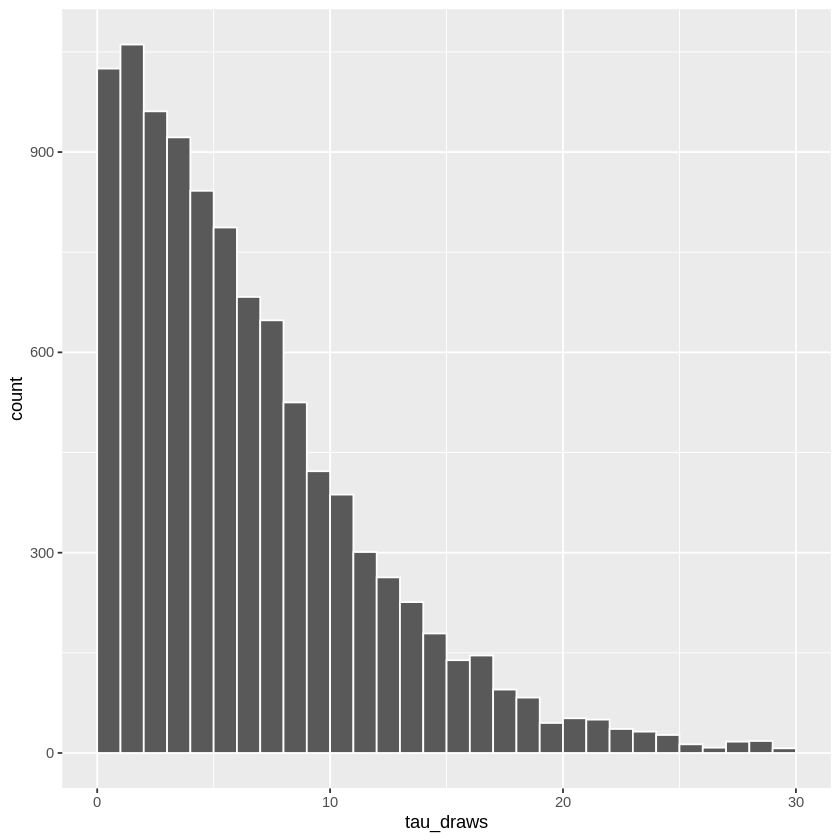

In [ ]:
N = 10000
uniform = runif(N, 0, 1)
tau_draws = rep(NA, N)
for (i in 1:N)
  tau_draws[i] = (sum(cdf < uniform[i])+1) * interval
ggplot(data.frame(tau_draws), aes(tau_draws)) + geom_histogram(binwidth = 1, center = 0.5, color = "white")


Alternatively, you can take the grid of $\tau$ we used to create the plot of $p(\tau|y)$ and sample from it weighted by the function value at each point. This seems to be a little noisier than the cdf method above.



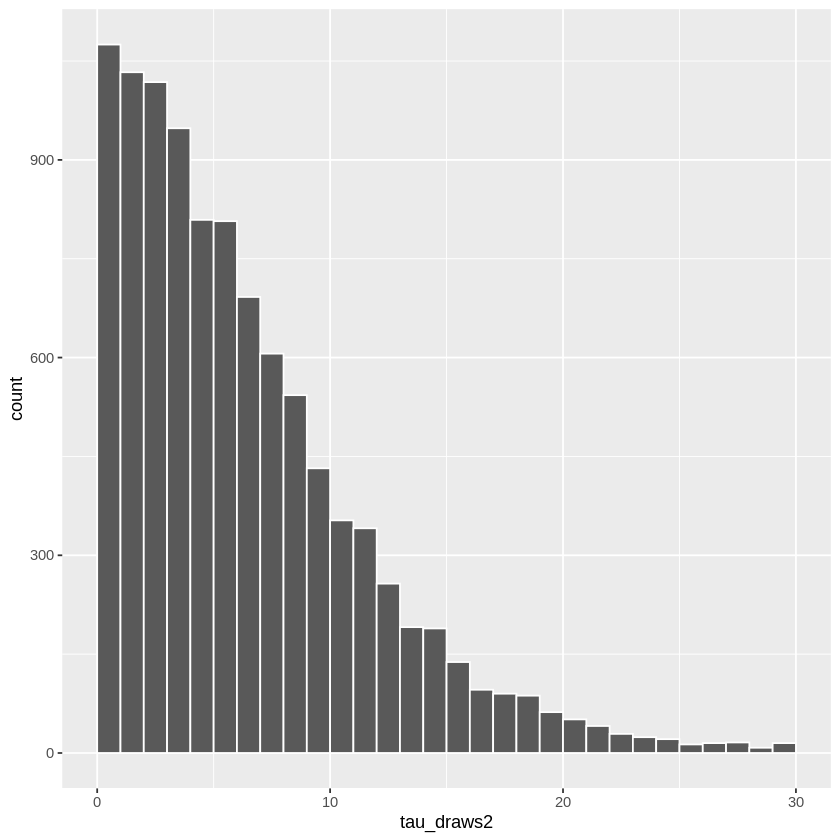

In [ ]:
tau_draws2 = sample(tau, N, replace = TRUE, prob = norm_post)
ggplot(data.frame(tau_draws2), aes(tau_draws2)) + geom_histogram(binwidth = 1, center = 0.5, color = "white")

## Simulating Everything Else

Conditioned on $\tau$, all other distributions are normal, making the rest of the simulation easy.

### Simulating $\mu|\tau, y$

From the top of page 117, this distribution is $\text{N}(\hat{\mu}, V_\mu)$, so we need to calculate $\hat{\mu}$ and $V_\mu$ for each of the draws of $\tau$ and then take a draw for $\mu$.




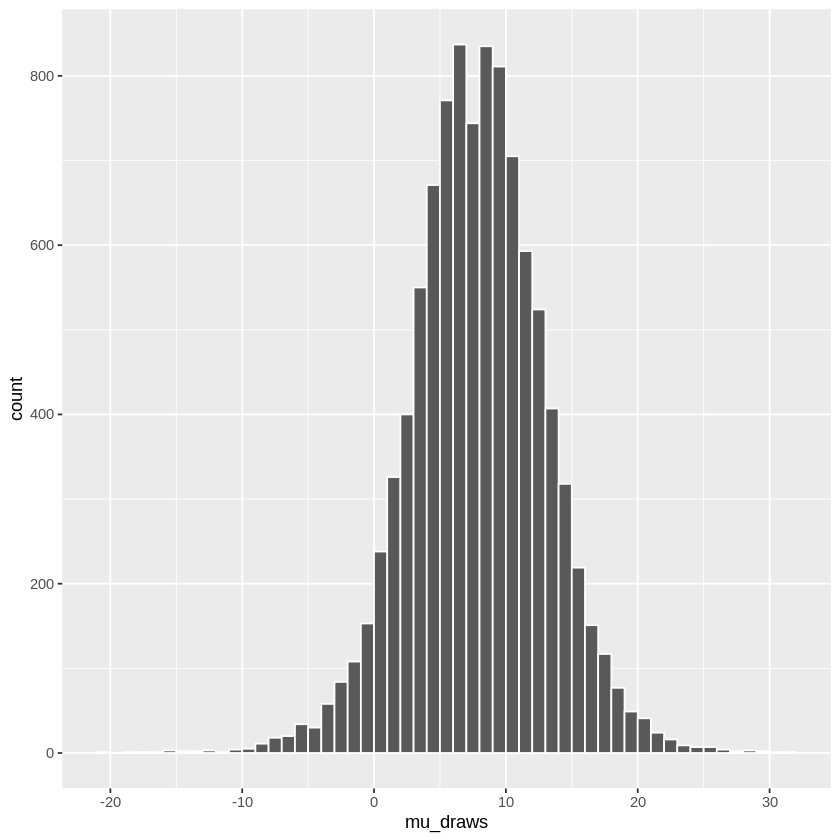

In [ ]:
mu_draws = rep(NA, N)
for (i in 1:N)
  mu_draws[i] = rnorm(1, mu_hat(y, sigma2, tau_draws[i]), var_inv(sigma2, tau_draws[i])^(-1/2))
ggplot(data.frame(mu_draws), aes(mu_draws)) + geom_histogram(binwidth = 1, center = 0.5, color = "white")

### Simulating $\theta_j|\mu, \tau, y$

Now we sample all of the $\theta_j$ for each $\tau, \mu$ pair that we have. This uses the normal distributions on page 116:

$$\theta_j|\mu, \tau, y \sim \text{N}(\hat{\theta}_j, V_j)$$
where
$$\begin{align*}
V_j &= \frac{1}{\frac{1}{\sigma^2_j} + \frac{1}{\tau^2}} \\
\hat{\theta}_j &= (\frac{1}{\sigma^2_j}\bar{y}_{.j} + \frac{1}{\tau^2}\mu) * V_j
\end{align*}$$





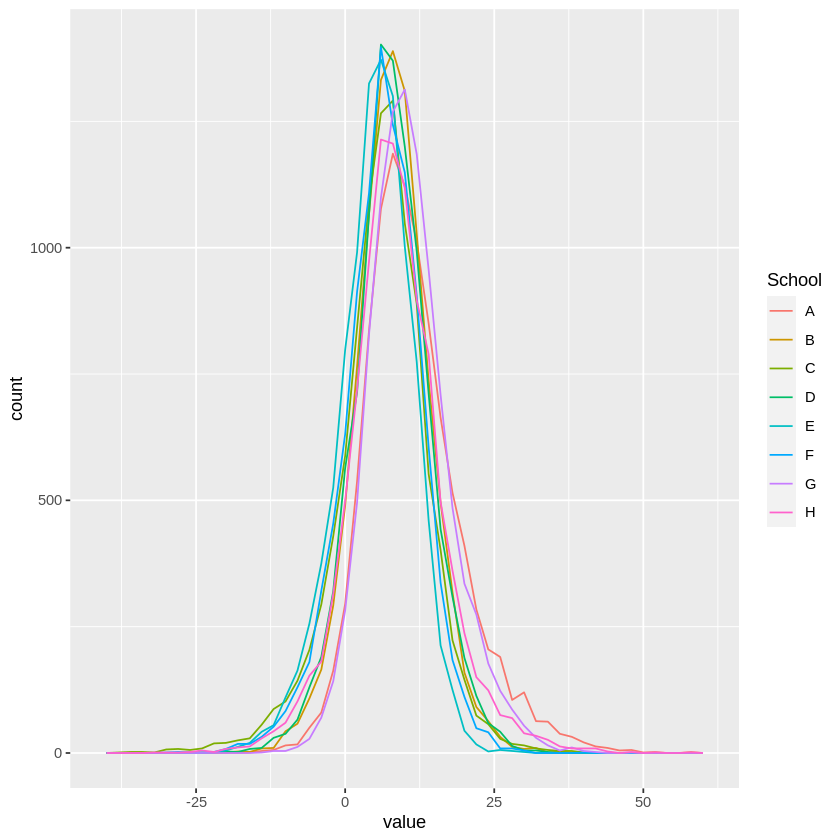

In [ ]:
theta_hat = V = theta_draws = matrix(NA, N, J)
for (j in 1:J){
  V[,j] = 1/ (sigma2[j]^-1 + tau_draws^-2)
  theta_hat[,j] = (y[j]/sigma2[j] + mu_draws/tau_draws^2) * V[,j] 
  theta_draws[, j] = rnorm(N, theta_hat[,j], V[,j]^(1/2))
}
ggplot(gather(data.frame(theta_draws)), aes(value, color=key)) + geom_freqpoly(binwidth=2) + 
  scale_color_discrete(name = "School", labels = c("A", "B", "C", "D", "E", "F", "G", "H"))

## Probability Table

Now to answer the question we take our `theta_draws` matrix and make all of the necessary comparisons.



In [ ]:
maxes = apply(theta_draws, 1, which.max)
prob_max = table(maxes) / N
comps = matrix(NA, J, J)
for (i in 1:(J-1)){
  for (j in (i+1):J){
    comps[i,j] = sum(theta_draws[,i] > theta_draws[,j]) / N
    comps[j,i] = 1 - comps[i,j]
  }
}
pmax = sprintf("%0.2f", prob_max)
comp_str = matrix(sprintf("%0.2f", comps), J, J)
comp_str[comp_str == "NA"] = "--"
schools = c("A", "B", "C", "D", "E", "F", "G", "H")
kable(cbind(schools, pmax, comp_str),
      format = "html", digits = 2,
      col.names = c("School", "Pr(Best)", schools)) %>%
  kable_styling(bootstrap_options = c("striped", "hover"))

<table class="table table-striped table-hover" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> School </th>
   <th style="text-align:left;"> Pr(Best) </th>
   <th style="text-align:left;"> A </th>
   <th style="text-align:left;"> B </th>
   <th style="text-align:left;"> C </th>
   <th style="text-align:left;"> D </th>
   <th style="text-align:left;"> E </th>
   <th style="text-align:left;"> F </th>
   <th style="text-align:left;"> G </th>
   <th style="text-align:left;"> H </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> A </td>
   <td style="text-align:left;"> 0.26 </td>
   <td style="text-align:left;"> -- </td>
   <td style="text-align:left;"> 0.63 </td>
   <td style="text-align:left;"> 0.69 </td>
   <td style="text-align:left;"> 0.64 </td>
   <td style="text-align:left;"> 0.74 </td>
   <td style="text-align:left;"> 0.70 </td>
   <td style="text-align:left;"> 0.52 </td>
   <td style="text-align:left;"> 0.62 </td>

# question 13

In [ ]:
#Load data
y <- c(16, 9  , 10 , 13 , 19 , 20 , 18 , 17 , 35 , 55 )
n <- c(74, 99 , 58 , 70 , 122, 77 , 104, 129, 308, 119)

In [ ]:
install.packages('nleqslv')
library(nleqslv)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
s.alpha = 

In [ ]:
s.theta = rbeta(1000, shape1 =s.alpha , shape2 = s.beta)   
CI.num = round(s.theta[order(s.theta)][c(25,975)],2)

[1] 0.1463415

2.5%     97.5% 
0.1463415 0.1463415

# gelman chapter 2

In [ ]:
# question 2.8

mean = 150.7
sd = 6.25
alpha = 0.05
qnorm(c(alpha/2, 1-alpha/2), mean, sd)

[1] 138.4502 162.9498

In [ ]:
# question 2.11

prod (dcauchy (1,1,1))

[1] 0.3183099

# Gelman chapter 10

In [ ]:
n = 1000

alpha = 0.05
sd = 1
S = 1e4
upper_accuracy_vec = NULL
lower_accuracy_vec = NULL

for (i in 1:S) {

  x = rnorm(n, 0, sd)

  quantiles = quantile(x, c(alpha/2, 1-alpha/2), names = F)
  lower_quantile_est = quantiles[1]
  upper_quantile_est = quantiles[2]

  lower_quantile_true = qnorm(alpha/2, 0, 1)
  upper_quantile_true = qnorm(1 - alpha/2, 0, 1)

  lower_accuracy = abs(lower_quantile_true - lower_quantile_est)
  upper_accuracy = abs(upper_quantile_true - upper_quantile_est)


  upper_accuracy_vec = c(upper_accuracy_vec, upper_accuracy)
  lower_accuracy_vec = c(lower_accuracy_vec, upper_accuracy)
  lower_accuracy_vec

}


mean(upper_accuracy_vec)
mean(lower_accuracy_vec)

[1] 0.06758286

[1] 0.06758286

In [ ]:
quantile(x, c(alpha/2, 1-alpha/2))[1]

2.5% 
-1.751649

In [ ]:

qnorm(1-alpha/2, 0, 1)

[1] 1.959964

question 2

In [ ]:
n = 100
x = rnorm(n, 8, 4)
mean(x)
sd(x)

[1] 8.014257

[1] 3.872514

In [ ]:
# (b)

n = 150
true_sd = 4

x = rnorm(n, 8, 4)
mean(x)
abs(sd(x) - 4)

[1] 7.912129

[1] 0.006218754

In [ ]:
# (c) and (d)

n = 100000
S = 1e4
true_sd = 4
alpha = 0.05
lower = NULL
upper = NULL

for (i in 1:S) {

  x = rnorm(n, 8, 4)
  quantiles = quantile(x, c(alpha/2, 1-alpha/2), names = F)
  lower = c(lower, quantiles[1])
  upper = c(upper, quantiles[2])

}

sd(lower)
sd(upper)

[1] 0.03404793

[1] 0.03388793

In [ ]:
# (e)
n = 200

x = rnorm(n, )

question 3

In [ ]:
n = 1000

n1 = 10
y1 = 6
n2 = 20
y2 = 10

p = 1
q = 1

p1 = rbeta(n, p + y1, q + n1 - y1)
p2 = rbeta(n, p + y2, q + n2 - y2)

diff = p1 - p2


quantiles = quantile(diff, c(1-alpha/2), names = F)
upper_quantile = quantiles[1]
upper_quantile

mean(p1 > p2)

[1] 0.4222719

[1] 0.699

question 5

In [ ]:
n = 100
f = function(y) {
  dt(y, df = 3)
}

y = runif(n)
w = f(y)
hist(log(w))

w_norm = w/sum(w)

d = density(y, weights = w_norm, from  = 0, to = 1)
mean(d$y)
sd(d$y)^2

# chapter 4

In [ ]:
# derivative
f = expression(x^2 * exp(-x))
dx2x = D(f,"x")
dx2x

2 * x * exp(-x) - x^2 * exp(-x)

In [ ]:
# 1

y = c(-2,-1,0,1.5,2.5)
n = length(y)


post = function(theta) {
  prod(1/(1+(y-theta)^2))
}

theta = runif(n, min = 0, max = 1)
# x = rcauchy(n, location = theta, scale = 1)
post(theta)



[1] 0.007486281

In [ ]:
# question 5
# (a)
n = 1e6
x = rnorm(n, 4, sqrt(1))
y = rnorm(n, 3, sqrt(2^2))

mean(y/x)
sd(y/x)

[1] 0.8120932

[1] 1.359333

# chapter 11

In [ ]:
install.packages('mvtnorm')
library(mvtnorm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('arm')
library(arm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘Formula’, ‘latticeExtra’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’, ‘lme4’, ‘abind’, ‘coda’, ‘Hmisc’


Loading required package: MASS

Loading required package: Matrix

Loading required package: lme4


arm (Version 1.11-2, built: 2020-7-27)


Working directory is /content




In [ ]:
# Data
x = c(-0.86, -0.30, -0.05,  0.73)
y = c(0, 1, 3, 5)
n = rep(5,4)
sims = 1e4
r_all = rep(0, sims)
accept = rep(0, sims)

theta = matrix(1, nrow = sims, ncol = 2)
theta[1,] = rep(1, 2)

In [ ]:
jumping = function(theta, scale = 0.1) {
    # rnorm(1, theta, scale)
  rmvnorm(1, mean = theta, sigma = scale*diag(2))
}


invlogit_neel = function(eta) {
    exp(eta)/(1 + exp(eta))
}

posterior = function(arg1) {
  alpha = arg1[1]
  beta = arg1[2]
  post = 1
  for (i in 1:length(y)) {
    post = post  * invlogit_neel(alpha + beta *x[i])^(y[i]) * (1 - invlogit_neel(alpha + beta*x[i]))^(n[i] - y[i])
    # cat('likelihood is ', likelihood, '\n')
    # cat('(1 - invlogit_neel(alpha + beta*x[i]))^(n[i] - y[i]) is ', (1 - invlogit_neel(alpha + beta*x[i]))^(n[i] - y[i]), '\n')
    # cat('invlogit_neel(alpha + beta *x[i])^(y[i]) is ', invlogit_neel(alpha + beta *x[i])^(y[i]), '\n')

  }
  post
}


for (i in 2:sims) {

  theta_star = jumping(theta[i-1,], 0.1)

  # cat('theta_star is ', theta_star, '\n')

  r = min(
          exp(log(posterior(theta_star))) - exp(log(posterior(theta[i-1,]))), 
          1
          )


  r_all[i] = r

  # cat('r is ', r, '\n')

  # print(runif(1, 0, 1))

  if (r < runif(1)) {
    theta[i,] = theta_star
    accept[i] = 1
  } else {
    theta[i,] = theta[i-1,]
  }
}


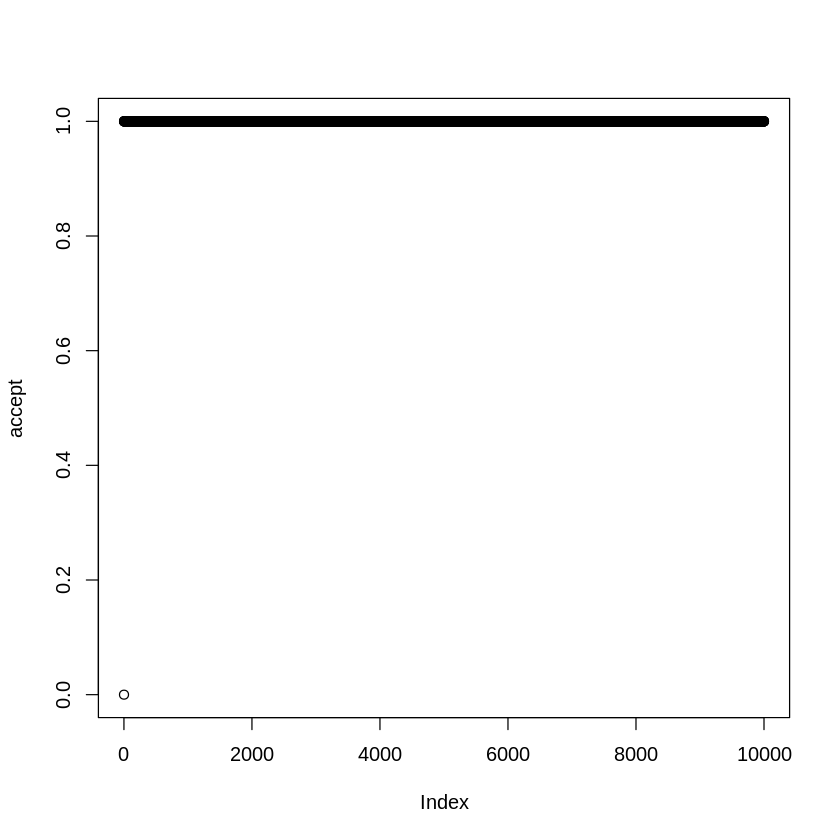

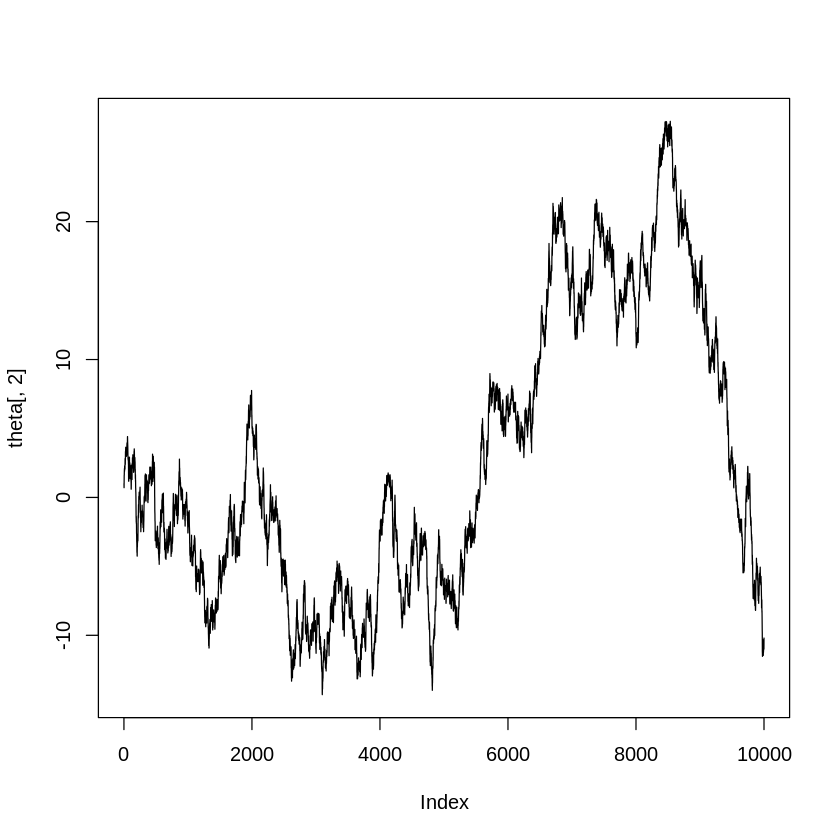

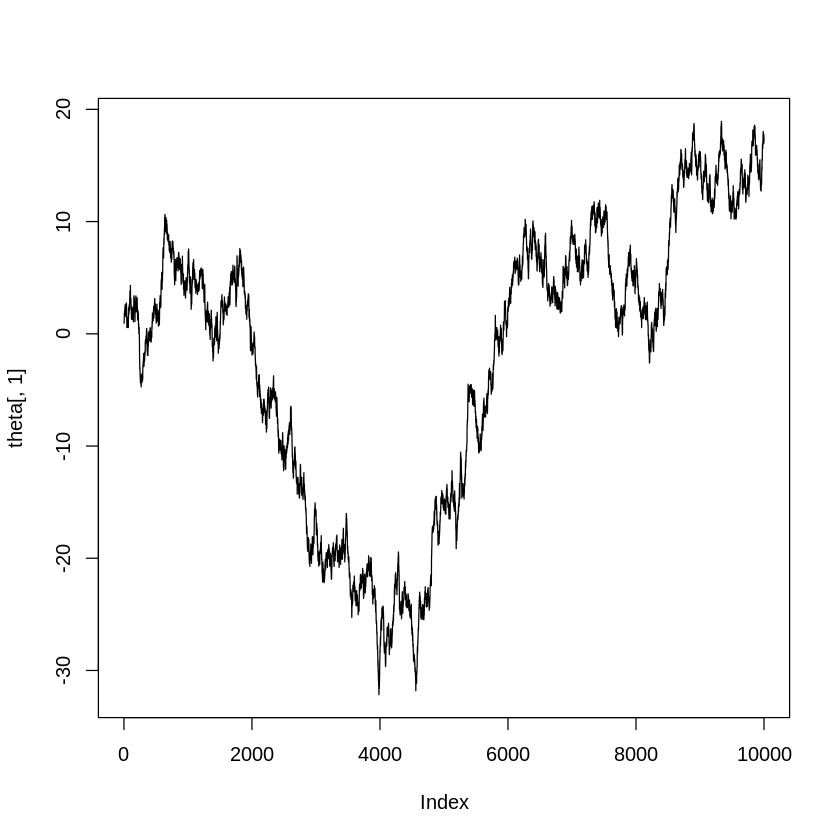

In [ ]:
plot(accept)
plot(theta[,2], type = 'l')
plot(theta[,1], type = 'l')